# Project 3 Notebook 3 - Model Benchmarks and Tuning

In [518]:
# Imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)

In [422]:
# Reading in Subreddit column and Title column
df = pd.read_csv('../project-3/data/subreddit_data.csv', usecols=[2,4])
df.head()

,subreddit,title
0,sleeptrain,I’m really feeling I’ve hit my limit
1,sleeptrain,How do you actually do PUPD?
2,sleeptrain,Going insane with early wakes.
3,sleeptrain,How did you extend nap time in crib?
4,sleeptrain,2.5 year old waking throughout night


#### My EDA indicated that although my Subreddit titles are somewhat similar there appear to be enough differences to make the modeling both possible and challenging. Therefore, I will use the Sureddit titles for modeling.

In [423]:
# Checking value counts of my target variable
df['subreddit'].value_counts(normalize = True)

sleeptrain             0.500753
AttachmentParenting    0.499247
Name: subreddit, dtype: float64

#### According to my value counts, my null model for my leading target is approximately 50%.

In [424]:
# Changing Subreddit Attachment PArenting to 1 and Sleep Training to 0
df['subreddit'] = df['subreddit'].replace({'AttachmentParenting' : 0, 'sleeptrain' : 1})

#### My EDA indicated that the Subreddit Title words (Sleep Training and Attachment Parenting) showed up a frequently in the respective Subreddit post titles. Therefore, I want to remove the words sleep, training, attachment, parenting and their variations to prevent my model from easily detecting which Subreddit category they came from.

In [425]:
# Calling .head(10) to find at least one instance of Subreddit Title word in title of post. The word 
# 'sleep' is present at index 6
df.head(10)

,subreddit,title
0,1,I’m really feeling I’ve hit my limit
1,1,How do you actually do PUPD?
2,1,Going insane with early wakes.
3,1,How did you extend nap time in crib?
4,1,2.5 year old waking throughout night
5,1,Help troubleshooting MOTN wake ups
6,1,Preparing for sleep coaching baby
7,1,Disrupted night sleep after starting daycare
8,1,How long did it take to sleep train?
9,1,How should i go about doing this?


In [426]:
# Creating my X and y data. I wil also remove my Subreddit Title words from my post titles to prevent from having
# to change my X and y variable names later. 
words_to_remove = '|'.join(['sleep', 'train', 'training', 'attachment', 'attach', 'parenting', 'parent','Sleep', 'Train', 'Training', 'Attachment', 'Attach', 'Parenting', 'Parent'])


X = df['title'].str.replace(words_to_remove, '', regex = True)

y = df['subreddit']

In [427]:
# Checking .head(10) to ensure Subreddit Title word 'sleep' is removed from title of post index #6
X.head(10)

0       I’m really feeling I’ve hit my limit
1               How do you actually do PUPD?
2             Going insane with early wakes.
3       How did you extend nap time in crib?
4       2.5 year old waking throughout night
5         Help troubleshooting MOTN wake ups
6               Preparing for  coaching baby
7    Disrupted night  after starting daycare
8                 How long did it take to  ?
9          How should i go about doing this?
Name: title, dtype: object

In [428]:
# And a sanity check for y just in case
y.head()

0    1
1    1
2    1
3    1
4    1
Name: subreddit, dtype: int64

#### I will train test split my data using random state 42 and stratify to begin optimizing my models for predicting class based on Subreddit post title text.

In [429]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

# Modeling with base models and stop words included in my Subreddit post titles.

#### Based on my EDA, I believe that my models should work best with cvec vectorization without stop words, using 2 grams and no lemmatization. However, I want to confirm this so I will run a few basic models without additional hyperparameter optimization initially to see if what I ascertained from my EDA is accurate.

## cvec with multinomialNB

In [430]:
# Modeling with cvec and MultinomialNB and running cross val score
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_nb, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.7960465650437248


In [431]:
# Looking at score for train and test data
pipe_cvec_nb.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_nb.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_nb.score(X_test, y_test)}')

Training Score: 0.8784326858673811
Testing Score: 0.8192771084337349


## tvec with multinomialNB

In [432]:
# Modeling with tvec and MultinomialNB and running cross val score.
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_nb, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8007355618673075


In [433]:
# Looking at score for train and test data
pipe_tvec_nb.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_nb.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_nb.score(X_test, y_test)}')

Training Score: 0.891158740790355
Testing Score: 0.8303212851405622


#### The scores for my cvec and tvec are not far off. Surprisingly my tvec is better than my cvec. My EDA suggested that the cvec would be a better method for classification so I am looking forward to seeing what happens when I remove stop words later. Next I will try random forest classifier.

## cvec with random forest

In [434]:
# Modeling with cvec and random forest and running cross val score
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8646958314426086


In [435]:
# Looking at score for train and test data
pipe_cvec_rf.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf.score(X_test, y_test)}')

Training Score: 0.9956463496316142
Testing Score: 0.9016064257028112


## tvec with random forest


In [436]:
# Modeling with tvec and random forest and running cross val score
pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8697226377147723


In [437]:
# Looking at score for train and test data
pipe_tvec_rf.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf.score(X_test, y_test)}')

Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


#### This time my tvec scored a little bit higher on my cross val score but a little bit lower on my test score. Judging from my cross val score and my test score, random forest is a model I want to consider or my final model(s).

## cvec with KNN

In [438]:
# Modeling with cvec and K nearest neighbors and running cross val score
pipe_cvec_kn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knneighbors', KNeighborsClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_kn, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.6908897889671322


In [439]:
# Looking at score for train and test data
pipe_cvec_kn.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_kn.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_kn.score(X_test, y_test)}')

Training Score: 0.8288680509042197
Testing Score: 0.7218875502008032


## tvec with KNN

In [440]:
# Modeling with tvec and K nearest neighbors and running cross val score
pipe_tvec_kn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knneighbors', KNeighborsClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_kn, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.6908897889671322


In [441]:
# Looking at score for train and test data
pipe_tvec_kn.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_kn.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_kn.score(X_test, y_test)}')

Training Score: 0.8288680509042197
Testing Score: 0.7218875502008032


#### I have not had much luck with KNN classifier the last two weeks in my practice with text but I wanted to try it anyway to see how it performed here. I do not feel compelled to use it as one of my final models as it scored much lower here as it did previously.

## cvec with adaboost and decision tree classifier as base estimator

In [442]:
# Modeling with cvec and adaboost with decision tree classifier as the base estimator and running cross val score
pipe_cvec_ada_dc = Pipeline([
    ('cvec', CountVectorizer()),
    ('adaboost', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42)))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_ada_dc, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8580040671585352


In [443]:
# Looking at score for train and test data
pipe_cvec_ada_dc.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_ada_dc.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_ada_dc.score(X_test, y_test)}')

Training Score: 0.9956463496316142
Testing Score: 0.8945783132530121


## tvec with adaboost and decision tree classifier as base estimator

In [444]:
# Modeling with tvec and adaboost with decision tree classifier as the base estimator and running cross val score
pipe_tvec_ada_dc = Pipeline([
    ('cvec', TfidfVectorizer()),
    ('adaboost', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42)))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_ada_dc, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8312129207912472


In [445]:
# Looking at score for train and test data
pipe_tvec_ada_dc.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_ada_dc.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_ada_dc.score(X_test, y_test)}')

Training Score: 0.9956463496316142
Testing Score: 0.8845381526104418


#### Adaboost worked almost as well as random forest. I want to try adaboost one more time with logregression but in the past I have had better luck with random forest. 

## cvec with adaboost and logistic regression as base estimator

In [446]:
# Modeling with cvec and adaboost with logistic regression as the base estimator and running cross val score
pipe_cvec_ada_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('adaboost', AdaBoostClassifier(base_estimator = LogisticRegression(random_state = 42)))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_ada_lr, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.7290588953687054


In [447]:
# Looking at score for train and test data
pipe_cvec_ada_lr.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_ada_lr.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_ada_lr.score(X_test, y_test)}')

Training Score: 0.7572002679169457
Testing Score: 0.7429718875502008


## tvec with adaboost and logistic regression as base estimator

In [448]:
# Modeling with tvec and adaboost with logistic regression as the base estimator and running cross val score
pipe_tvec_ada_lr = Pipeline([
    ('cvec', TfidfVectorizer()),
    ('adaboost', AdaBoostClassifier(base_estimator = LogisticRegression(random_state = 42)))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_ada_lr, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.7407825078570107


In [449]:
# Looking at score for train and test data
pipe_tvec_ada_lr.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_ada_lr.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_ada_lr.score(X_test, y_test)}')

Training Score: 0.7699263228399196
Testing Score: 0.7459839357429718


#### As I expected, log regression did not perform as well as decision tree classifier but it did perform better than I expected. I may try to use it in a stack after I have finished tuning my models.

# Modeling with base models and stop words removed from my Subreddit post titles.

#### My EDA suggests that removing stopwords should improve my models. I am going to continue modeling with my top 3 models from the previous section (multinomialNB, random forest and adaboost with decision tree classifier as the base estimator)

## cvec with multinomialNB no stop words

In [450]:
# Modeling with cvec and MultinomialNB no stop words and running cross val score
pipe_cvec_nb_sw = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'))),
    ('nb', MultinomialNB())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_nb_sw, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.789011949379002


In [451]:
# Looking at score for train and test data
pipe_cvec_nb_sw.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_nb_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_nb_sw.score(X_test, y_test)}')

Training Score: 0.8864701942397857
Testing Score: 0.8152610441767069


In [452]:
# cvec base model with stop words scores
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_nb, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_nb.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_nb.score(X_test, y_test)}')

Cross_Val_Score: 0.7960465650437248
Training Score: 0.8784326858673811
Testing Score: 0.8192771084337349


#### According to my scores my model perfromed a little better with stop words

## tvec with multinomialNB no stop words

In [453]:
# Modeling with tvec and MultinomialNB no stop words and running cross val score.
pipe_tvec_nb_sw = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('nb', MultinomialNB())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_nb_sw, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.7990571587032151


In [454]:
# Looking at score for train and test data
pipe_tvec_nb_sw.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_nb_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_nb_sw.score(X_test, y_test)}')

Training Score: 0.8975217682518419
Testing Score: 0.820281124497992


In [455]:
# tvec base model with stop words scores
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_nb, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_nb.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_nb.score(X_test, y_test)}')

Cross_Val_Score: 0.8007355618673075
Training Score: 0.891158740790355
Testing Score: 0.8303212851405622


#### somehow my tvec with stopwords and without scored exactly the same. That seems a little suspicious but I double checked and the code and variables are accurate.

#### My multinomialNB performed almost the same without stopwords as it did with stopwords. I was expecting the model to perform better without stopwords based on my EDA as removing stopwords for my tvec vectorizing reduced the number of the top 25 words in the post titles that were common between sleep training and attachment parenting posts from 17 to 11. I am curious to see if my other models will perform better.

## cvec with random forest no stop words

In [456]:
# Modeling with cvec and random forest no stop words and running cross val score
pipe_cvec_rf_sw = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'))),
    ('rf', RandomForestClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf_sw, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8533089079735354


In [457]:
# Looking at score for train and test data
pipe_cvec_rf_sw.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_rf_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf_sw.score(X_test, y_test)}')

Training Score: 0.9922973878097789
Testing Score: 0.8795180722891566


In [458]:
# cvec base model with stop words scores
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8636896858876322
Training Score: 0.9956463496316142
Testing Score: 0.9016064257028112


#### Just like my last cvec with multinomialNB, my random forest model also performed a little worse with stopwords removed. 

## tvec with random forest no stop words

In [459]:
# Modeling with tvec and random forest no stop words and running cross val score
pipe_tvec_rf_sw = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('rf', RandomForestClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf_sw, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8656958146361685


In [460]:
# Looking at score for train and test data
pipe_tvec_rf_sw.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_rf_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf_sw.score(X_test, y_test)}')

Training Score: 0.9922973878097789
Testing Score: 0.8885542168674698


In [461]:
# tvec base model with stop words scores
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.870054284801936
Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


#### Here, like cvec previously, my model with stop words included outperforms my model with stop words removed. For my final model I will not remove stop words.

#### Removing stop words actually made both random forest models perform slightly worse than before. My cross val score for cvec was 0.8590107729281862 and tvec was 0.8647025540187. Likewise, my training and test scores for both cvec and tvec were about 2% points less as well. I am glad that I ran these tests as I was almost convinced that removing stopwords would have improved my model based on the EDA that I performed.

## cvec with adaboost and decision tree classifier as base estimator no stop words

In [462]:
# Modeling with cvec no stop words and adaboost with decision tree classifier as the base estimator and running cross val score
pipe_cvec_ada_sw = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords.words('english'))),
    ('adaboost', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42)))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_ada_sw, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8442687237749504


In [463]:
# Looking at score for train and test data
pipe_cvec_ada_sw.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_ada_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_ada_sw.score(X_test, y_test)}')

Training Score: 0.9922973878097789
Testing Score: 0.8684738955823293


In [464]:
# cvec base model with stop words scores
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_ada_dc, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_ada_dc.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_ada_dc.score(X_test, y_test)}')

Cross_Val_Score: 0.846277093382184
Training Score: 0.9956463496316142
Testing Score: 0.8945783132530121


#### My adaboost model for cvec also performs better with stop words. Again, not by much but still better.

## tvec with adaboost and decision tree classifier as base estimator no stop words

In [465]:
# Modeling with tvec no stop words and adaboost with decision tree classifier as the base estimator and running cross val score
pipe_tvec_ada_sw = Pipeline([
    ('cvec', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('adaboost', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42)))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_ada_sw, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8409236819549252


In [466]:
# Looking at score for train and test data
pipe_tvec_ada_sw.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_ada_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_ada_sw.score(X_test, y_test)}')

Training Score: 0.9922973878097789
Testing Score: 0.8795180722891566


In [467]:
# tvec base model with stop words scores
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_ada_dc, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_ada_dc.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_ada_dc.score(X_test, y_test)}')

Cross_Val_Score: 0.8288706632381528
Training Score: 0.9956463496316142
Testing Score: 0.8845381526104418


### The same thing here as with my random tree. My cross val scores and my train and test scores are a little lower. I was planning on modeling with stop words based on what I saw in my EDA in reducing the number of common words between my 2 Subreddit categories. However, now I will most likely model with stop words.

### I was initially planning on modeling 2 grams with stop words removed but seeing how removing stop words has inhibited the performance of my model I am going to try 2 grams with stop words included and compare against my base random forest model.

# Modeling with random forest base model with 2 grams.

## cvec with 2 grams and random forest 

In [468]:
# Modeling with cvec 2 grams and random forest and running cross val score
pipe_cvec_rf_2gr = Pipeline([
    ('cvec', CountVectorizer(ngram_range=(2,2))),
    ('rf', RandomForestClassifier(random_state = 42))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf_2gr, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8171397679590819


In [469]:
# Looking at score for train and test data
pipe_cvec_rf_2gr.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_rf_2gr.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf_2gr.score(X_test, y_test)}')

Training Score: 0.9906229068988613
Testing Score: 0.8775100401606426


In [470]:
# cvec base model no 2 gramss
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8683809235699119
Training Score: 0.9956463496316142
Testing Score: 0.9016064257028112


#### Including 2 grams scored a little worse than without them. Nevertheless, I will try with tvec as well.

## tvec with 2 grams and random forest 

In [471]:
# Modeling with tvec 2 grams and random forest and running cross val score
pipe_tvec_rf_2gr = Pipeline([
    ('tvec', TfidfVectorizer(ngram_range=(2,2))),
    ('rf', RandomForestClassifier(random_state = 42))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf_2gr, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8201554035506404


In [472]:
# Looking at score for train and test data
pipe_tvec_rf_2gr.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_rf_2gr.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf_2gr.score(X_test, y_test)}')

Training Score: 0.9906229068988613
Testing Score: 0.8724899598393574


In [473]:
# tvec base model with stop words and no 2 grams
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8703898533918197
Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


#### Again, including 2 grams reduced my scores. I will not include 2 grams for my final models.

#### When I performed EDA on my dataset creating 2 grams reduced the number of the top 25 words that the two Subreddit categories had in common to 7 and 9 respectively for tvec and cvec. I thought that would aid the model in classification but the model is performing worse with 2 grams included. I want to try 3 grams as well to see what affect that has on the score. I thought that it would reduce the score as the 2 grams had 2 less words in common between the 2 groups but it may perform better based on my previous predictions being off the mark.

# Modeling with random forest base model and stop words removed from my Subreddit post titles and 3 grams.


## cvec with 3 grams and random forest 

In [474]:
# Modeling with cvec 3 grams and random forest and running cross val score
pipe_cvec_rf_3gr = Pipeline([
    ('cvec', CountVectorizer(ngram_range=(3,3))),
    ('rf', RandomForestClassifier(random_state = 42))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf_3gr, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.7839913054682554


In [475]:
# Looking at score for train and test data
pipe_cvec_rf_3gr.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_rf_3gr.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf_3gr.score(X_test, y_test)}')

Training Score: 0.9614869390488948
Testing Score: 0.8423694779116466


In [476]:
# cvec base model with stop words and no 3 grams
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8616807560657245
Training Score: 0.9956463496316142
Testing Score: 0.9016064257028112


#### Including 3 grams reduced my model scores as well.

## tvec with 3 grams and random forest 

In [477]:
# Modeling with tvec 3 grams and random forest and running cross val score
pipe_tvec_rf_3gr = Pipeline([
    ('tvec', TfidfVectorizer(ngram_range=(3,3))),
    ('rf', RandomForestClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf_3gr, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.7846607620039999


In [478]:
# Looking at score for train and test data
pipe_tvec_rf_3gr.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_rf_3gr.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf_3gr.score(X_test, y_test)}')

Training Score: 0.9614869390488948
Testing Score: 0.8453815261044176


In [479]:
# tvec base model with stop words and no 2 grams
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8757466261071242
Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


#### As with cvec above including 3 grams reduced my scores. I will not be including 3 grams in my final model. 

#### This is at least one prediction I got correct! The 3 grams do not improve the model. in fact, the 3 grams cause the model to score approximately 6% less across the board. Before I move on to optimizing my models I want to try lemmitization.

# Modeling with random forest base model and stop words removed from my Subreddit post titles and lemmatization.

## cvec with lemmatization and random forest

In [480]:
# Custom tokenizing - using the lemmatizer function we made during our breakfast hour 
def my_lemmatizer(text):
    wnet = WordNetLemmatizer()
    return [wnet.lemmatize(w) for w in text.split(" ")]

In [481]:
# apply same pre-processing as posts to stopwords- this prevents my tokenizer from returning errors 
# that it no longer recognizes the stop words in my text that have been lemmatized
wnet = WordNetLemmatizer()
lem_stopwords = [wnet.lemmatize(w) for w in stopwords.words('english')]

In [482]:
# Modeling with cvec no stop words lemmatized and random forest and running cross val score
pipe_cvec_rf_sw_lm = Pipeline([
    ('cvec', CountVectorizer(stop_words=lem_stopwords, tokenizer = my_lemmatizer)),
    ('rf', RandomForestClassifier(random_state = 42))
])

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf_sw_lm, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8663686324599587


In [483]:
# Looking at score for train and test data
pipe_cvec_rf_sw_lm.fit(X_train, y_train)
print(f'Training Score: {pipe_cvec_rf_sw_lm.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf_sw_lm.score(X_test, y_test)}')

Training Score: 0.9973208305425318
Testing Score: 0.8965863453815262


In [484]:
# cvec base model with stop words removed no lemmitization
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf_sw, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_rf_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf_sw.score(X_test, y_test)}')

Cross_Val_Score: 0.8549861907082794
Training Score: 0.9922973878097789
Testing Score: 0.8795180722891566


In [485]:
# cvec base model with stop words no lemmitization
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8680431141213314
Training Score: 0.9956463496316142
Testing Score: 0.9016064257028112


#### Lemmatization did help improve the score of the model with the stop words removed, however, it still does not perform as well as the model with stop words included.

## tvec with lemmatization and random forest

In [486]:
# Modeling with tvec no stop words lemmatized and random forest and running cross val score
pipe_tvec_rf_sw_lm = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=lem_stopwords, tokenizer = my_lemmatizer)),
    ('rf', RandomForestClassifier())
])

print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf_sw_lm, X_train, y_train, cv = 5).mean()}')

Cross_Val_Score: 0.8680459151947026


In [487]:
# Looking at score for train and test data
pipe_tvec_rf_sw_lm.fit(X_train, y_train)
print(f'Training Score: {pipe_tvec_rf_sw_lm.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf_sw_lm.score(X_test, y_test)}')

Training Score: 0.9973208305425318
Testing Score: 0.8955823293172691


In [488]:
# tvec base model with stop words removed no lemmitization
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf_sw, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_rf_sw.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf_sw.score(X_test, y_test)}')

Cross_Val_Score: 0.8653664084077018
Training Score: 0.9922973878097789
Testing Score: 0.8885542168674698


In [489]:
# tvec base model with stop words no lemmitization
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8680464754093767
Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


#### As with cvec, my tvec score with lemmatization and stop words removed was better than it was for just stop words removed. However, it did not score as high as my base model, therefore, I will continue on with my base model.

#### Lemmatization did not score as well as my bare random forest but it scored better than I thought it would. It only scored between 1% and 2% less than my bare random forest. My EDA showed that lemmatization introduced several numbers and special characters into my top 25 words for both my Subreddits but apparently that was more useful for classification than removing stop words. 

## Comparing my best cvec models to my best cvec models

### multinomialNB base models

In [490]:
# cvec base model with stop words
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_nb, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_nb.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_nb.score(X_test, y_test)}')

Cross_Val_Score: 0.7960465650437248
Training Score: 0.8784326858673811
Testing Score: 0.8192771084337349


In [491]:
# tvec base model with stop words
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_nb, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_nb.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_nb.score(X_test, y_test)}')

Cross_Val_Score: 0.8007355618673075
Training Score: 0.891158740790355
Testing Score: 0.8303212851405622


### random forest base models

In [492]:
# cvec base model with stop words 
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8713931978734252
Training Score: 0.9956463496316142
Testing Score: 0.9016064257028112


In [493]:
# tvec base model with stop words 
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8717310073220057
Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


### adaboost with decision tree base model

In [494]:
# cvec base model with stop words 
print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_ada_dc, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_ada_dc.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_ada_dc.score(X_test, y_test)}')

Cross_Val_Score: 0.851638908029557
Training Score: 0.9956463496316142
Testing Score: 0.8945783132530121


In [495]:
# tvec base model with stop words 
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_ada_dc, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_ada_dc.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_ada_dc.score(X_test, y_test)}')

Cross_Val_Score: 0.8358985563267843
Training Score: 0.9956463496316142
Testing Score: 0.8845381526104418


#### Since tvec has consistently scored higher than cvec (albeit not by much) I will conitnue on using tvec alone. My best models are random forest, adaboost and multinomialNB. I will use these in conjunction with tvec for hyperparameter optimization using gridsearch to improve my models.

# Gridsearch for optimizing hyperparamters for multinomialNB

## Gridsearch for optimizing hyperparamters for multinomialNB

In [496]:
# Gridsearching hyperparameters for multinomialNB #1

pipe_tvec_nb_hp_1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvec_nb_hp_params_1 = {
    'tvec__max_features': [6000, 8000, 10000, 12000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.85, 0.9, 0.95]
}

gs_pipe_tvec_nb_hp_1 = GridSearchCV(pipe_tvec_nb_hp_1, param_grid = pipe_tvec_nb_hp_params_1, cv = 5)

gs_pipe_tvec_nb_hp_1.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_nb_hp_1.best_score_}')
print(f'Training Score: {gs_pipe_tvec_nb_hp_1.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_nb_hp_1.score(X_test, y_test)}')
gs_pipe_tvec_nb_hp_1.best_params_

Cross_Val_Score: 0.8007355618673075
Training Score: 0.891158740790355
Testing Score: 0.8303212851405622


{'tvec__max_df': 0.85, 'tvec__max_features': 6000, 'tvec__min_df': 1}

In [497]:
# My original tvec with multinomialNB scores

print(f'Cross_Val_Score: {cross_val_score(pipe_cvec_nb, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_cvec_nb.score(X_train, y_train)}')
print(f'Testing Score: {pipe_cvec_nb.score(X_test, y_test)}')

Cross_Val_Score: 0.7960465650437248
Training Score: 0.8784326858673811
Testing Score: 0.8192771084337349


#### My hyperparameter grdsearch yielded better scores than my original scores. they are not largely different but a little better. I will try a little more hyperparameter optimization to see if I can beet my first Gridsearch scores

In [498]:
# Gridsearching hyperparameters for multinomialNB #2

pipe_tvec_nb_hp_2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvec_nb_hp_params_2 = {
    'tvec__max_features': [2000, 4000, 6000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.65, 0.75, 0.85]
}

gs_pipe_tvec_nb_hp_2 = GridSearchCV(pipe_tvec_nb_hp, param_grid = pipe_tvec_nb_hp_params_2, cv = 5)

gs_pipe_tvec_nb_hp_2.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_nb_hp_2.best_score_}')
print(f'Training Score: {gs_pipe_tvec_nb_hp_2.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_nb_hp_2.score(X_test, y_test)}')
gs_pipe_tvec_nb_hp_2.best_params_

Cross_Val_Score: 0.8007355618673075
Training Score: 0.891158740790355
Testing Score: 0.8303212851405622


{'tvec__max_df': 0.65, 'tvec__max_features': 2000, 'tvec__min_df': 1}

In [499]:
# Gridsearching hyperparameters for multinomialNB #3

pipe_tvec_nb_hp_3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvec_nb_hp_params_3 = {
    'tvec__max_features': [100, 250, 500, 750, 1000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [0.45, 0.55, 0.65, 0.75]
}

gs_pipe_tvec_nb_hp_3 = GridSearchCV(pipe_tvec_nb_hp, param_grid = pipe_tvec_nb_hp_params_3, cv = 5)

gs_pipe_tvec_nb_hp_3.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_nb_hp_3.best_score_}')
print(f'Training Score: {gs_pipe_tvec_nb_hp_3.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_nb_hp_3.score(X_test, y_test)}')
gs_pipe_tvec_nb_hp_3.best_params_

Cross_Val_Score: 0.7796339557318365
Training Score: 0.8523107836570664
Testing Score: 0.8002008032128514


{'tvec__max_df': 0.45, 'tvec__max_features': 1000, 'tvec__min_df': 1}

#### My scores keep going down as I continue to fien tune my hyperparameters. It appears that I was able to maximize the scores in the first gridsearch.


## Gridsearch for optimizing hyperparamters for random forest 

In [500]:
# Gridsearching hyperparameters for random forest #1

pipe_tvec_rf_hp_1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

pipe_tvec_rf_hp_params_1 = {
    'tvec__max_features': [6000, 8000],
    'tvec__max_df': [0.6, 0.7],
    'rf__n_estimators': [50, 75, 100],
    'rf__max_depth': [15, 30],
    'rf__ccp_alpha': [0.01, 0.1, 1.0],
    'rf__min_samples_leaf': range(2, 4)
}

gs_pipe_tvec_rf_hp_1 = GridSearchCV(pipe_tvec_rf_hp_1, param_grid = pipe_tvec_rf_hp_params_1, cv = 3)

gs_pipe_tvec_rf_hp_1.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_rf_hp_1.best_score_}')
print(f'Training Score: {gs_pipe_tvec_rf_hp_1.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_rf_hp_1.score(X_test, y_test)}')
gs_pipe_tvec_rf_hp_1.best_params_

Cross_Val_Score: 0.6423412241932555
Training Score: 0.6550569323509712
Testing Score: 0.6375502008032129


{'rf__ccp_alpha': 0.01,
 'rf__max_depth': 15,
 'rf__min_samples_leaf': 2,
 'rf__n_estimators': 100,
 'tvec__max_df': 0.6,
 'tvec__max_features': 6000}

In [501]:
# Gridsearching hyperparameters for random forest #2

pipe_tvec_rf_hp_2 = Pipeline([
    ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
    ('rf', RandomForestClassifier(random_state = 42))
])

pipe_tvec_rf_hp_params_2 = {
    'rf__n_estimators': [100, 125, 150],
    'rf__max_depth': [5, 10, 15],
    'rf__ccp_alpha': [0.005, 0.01],
    'rf__min_samples_leaf': [1, 2]
}

gs_pipe_tvec_rf_hp_2 = GridSearchCV(pipe_tvec_rf_hp_2, param_grid = pipe_tvec_rf_hp_params_2, cv = 3)

gs_pipe_tvec_rf_hp_2.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_rf_hp_2.best_score_}')
print(f'Training Score: {gs_pipe_tvec_rf_hp_2.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_rf_hp_2.score(X_test, y_test)}')
gs_pipe_tvec_rf_hp_2.best_params_

Cross_Val_Score: 0.7240442507046612
Training Score: 0.7427997320830543
Testing Score: 0.7279116465863453


{'rf__ccp_alpha': 0.005,
 'rf__max_depth': 15,
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 125}

#### The optimal max depth seems to be best at 15 so I am going to set that to 15.

In [502]:
# Gridsearching hyperparameters for random forest #3

pipe_tvec_rf_hp_3 = Pipeline([
    ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 15))
])

pipe_tvec_rf_hp_params_3 = {
    'rf__n_estimators': [150, 200, 300],
    'rf__ccp_alpha': [0, 0.001,0.005],
    'rf__min_samples_split': [4, 10, 20, 50]
    
}

gs_pipe_tvec_rf_hp_3 = GridSearchCV(pipe_tvec_rf_hp_3, param_grid = pipe_tvec_rf_hp_params_3, cv = 3)

gs_pipe_tvec_rf_hp_3.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_rf_hp_3.best_score_}')
print(f'Training Score: {gs_pipe_tvec_rf_hp_3.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_rf_hp_3.score(X_test, y_test)}')
gs_pipe_tvec_rf_hp_3.best_params_

Cross_Val_Score: 0.7772897284279496
Training Score: 0.8556597454789016
Testing Score: 0.7961847389558233


{'rf__ccp_alpha': 0, 'rf__min_samples_split': 4, 'rf__n_estimators': 200}

#### The default alpha is 0 so leaving that default and I am going to increase my n_estimators. I will also look at numbers below 4 for my n_estimators.

In [503]:
# Gridsearching hyperparameters for random forest #4

pipe_tvec_rf_hp_4 = Pipeline([
    ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
    ('rf', RandomForestClassifier(random_state = 42))
])

pipe_tvec_rf_hp_params_4 = {
    'rf__n_estimators': [300, 400, 500, 600],
    'rf__min_samples_split': [2, 3, 4]
    
}

gs_pipe_tvec_rf_hp_4 = GridSearchCV(pipe_tvec_rf_hp_4, param_grid = pipe_tvec_rf_hp_params_4, cv = 3)

gs_pipe_tvec_rf_hp_4.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_rf_hp_4.best_score_}')
print(f'Training Score: {gs_pipe_tvec_rf_hp_4.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_rf_hp_4.score(X_test, y_test)}')
gs_pipe_tvec_rf_hp_4.best_params_

Cross_Val_Score: 0.8472869703268686
Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


{'rf__min_samples_split': 2, 'rf__n_estimators': 600}

In [504]:
# tvec base model with stop words 
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_rf, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_rf.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_rf.score(X_test, y_test)}')

Cross_Val_Score: 0.8703909738211681
Training Score: 0.9956463496316142
Testing Score: 0.8895582329317269


#### I was able to move the needle a little bit on my test score but my cross val score was reduced by 3%. When I create my final stack model I will use my base random forest classifier and my optimized hyperparameters here to see which ultimately scores best in my stack.

## Gridsearch for optimizing hyperparamters for adaboost

In [505]:
# Gridsearching hyperparameters for adaboost #1

pipe_tvec_ad_hp_1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ad', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state = 42)))
])

pipe_tvec_ad_hp_params_1 = {
    'ad__base_estimator__ccp_alpha': [0.01, 0.1],
    'ad__base_estimator__min_samples_leaf': [2, 4],
    'ad__n_estimators': [25, 50 , 100],
    'ad__learning_rate': [0.5, 0.75, 1]
}

gs_pipe_tvec_ad_hp_1 = GridSearchCV(pipe_tvec_ad_hp_1, param_grid = pipe_tvec_ad_hp_params_1, cv = 3)

gs_pipe_tvec_ad_hp_1.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_ad_hp_1.best_score_}')
print(f'Training Score: {gs_pipe_tvec_ad_hp_1.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_ad_hp_1.score(X_test, y_test)}')
gs_pipe_tvec_ad_hp_1.best_params_

Cross_Val_Score: 0.6131917956583453
Training Score: 0.601138647019424
Testing Score: 0.5863453815261044


{'ad__base_estimator__ccp_alpha': 0.01,
 'ad__base_estimator__min_samples_leaf': 2,
 'ad__learning_rate': 0.5,
 'ad__n_estimators': 25}

#### It appears as though the ccp_alpha and min_samples_leaf hyperparameters are ideal at the default values, which explains why my gridsearch model is not performing as well as my base model. I will remove those from my next search and leave them with their default values.

In [506]:
# Gridsearching hyperparameters for adaboost #2

pipe_tvec_ad_hp_2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ad', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state = 42)))
])

pipe_tvec_ad_hp_params_2 = {
    'ad__base_estimator__min_samples_split': [4, 6, 8],
    'ad__n_estimators': [5, 10, 15, 20, 25],
    'ad__learning_rate': [0.70, 0.75, 0.80]
}

gs_pipe_tvec_ad_hp_2 = GridSearchCV(pipe_tvec_ad_hp_2, param_grid = pipe_tvec_ad_hp_params_2, cv = 3)

gs_pipe_tvec_ad_hp_2.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_ad_hp_2.best_score_}')
print(f'Training Score: {gs_pipe_tvec_ad_hp_2.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_ad_hp_2.score(X_test, y_test)}')
gs_pipe_tvec_ad_hp_2.best_params_

Cross_Val_Score: 0.8214933435584886
Training Score: 0.9956463496316142
Testing Score: 0.8855421686746988


{'ad__base_estimator__min_samples_split': 8,
 'ad__learning_rate': 0.75,
 'ad__n_estimators': 25}

### Restoring the defaults mentioned above and digging deeper into the min_samples_leaf, learning_rate and n_estimators is paying off. I will try one more time with more granular values.

In [507]:
# Gridsearching hyperparameters for adaboost #3

pipe_tvec_ad_hp_3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ad', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state = 42)))
])

pipe_tvec_ad_hp_params_3 = {
    'ad__base_estimator__min_samples_split': [8, 10, 12, 14],
    'ad__n_estimators': [14, 15, 16],
    'ad__learning_rate': [0.73, 0.75, 0.77]
}

gs_pipe_tvec_ad_hp_3 = GridSearchCV(pipe_tvec_ad_hp_3, param_grid = pipe_tvec_ad_hp_params_3, cv = 3)

gs_pipe_tvec_ad_hp_3.fit(X_train, y_train)
print(f'Cross_Val_Score: {gs_pipe_tvec_ad_hp_3.best_score_}')
print(f'Training Score: {gs_pipe_tvec_ad_hp_3.score(X_train, y_train)}')
print(f'Testing Score: {gs_pipe_tvec_ad_hp_3.score(X_test, y_test)}')
gs_pipe_tvec_ad_hp_3.best_params_

Cross_Val_Score: 0.8298709074152556
Training Score: 0.9956463496316142
Testing Score: 0.8945783132530121


{'ad__base_estimator__min_samples_split': 14,
 'ad__learning_rate': 0.75,
 'ad__n_estimators': 15}

In [508]:
# tvec base model 
print(f'Cross_Val_Score: {cross_val_score(pipe_tvec_ada_dc, X_train, y_train, cv = 5).mean()}')
print(f'Training Score: {pipe_tvec_ada_dc.score(X_train, y_train)}')
print(f'Testing Score: {pipe_tvec_ada_dc.score(X_test, y_test)}')

Cross_Val_Score: 0.8332184893251092
Training Score: 0.9956463496316142
Testing Score: 0.8845381526104418


#### Even with the hyperparameter search my model is still performing better as the base model. This is unexpected but I will continue with my base model as it is still scoring higher.

# Stacking my models

## Stacking with my base tvec vectorizer and base random forest model

In [509]:
level1_estimators = [
    ('rf_pipe_1', Pipeline([
        ('tvec', TfidfVectorizer()),
        ('rf', RandomForestClassifier(random_state = 42))])),
    ('nb_pipe', Pipeline([
        ('tvec', TfidfVectorizer()),
        ('nb', MultinomialNB())])),
    ('ad_pipe', Pipeline([
        ('tvec', TfidfVectorizer()),
        ('rf', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42)))]))
]

stacked_model_1 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression())

stacked_model_1.fit(X_train, y_train)
print(f'Train Score: {stacked_model_1.score(X_train, y_train)}')
print(f'Test Score: {stacked_model_1.score(X_test, y_test)}')

Train Score: 0.9953114534494307
Test Score: 0.9046184738955824


## Stacking with my optimized hyperparameter tvec vectorizer and base random forst 

In [520]:
level1_estimators = [
    ('rf_pipe_1', Pipeline([
        ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
        ('rf', RandomForestClassifier(random_state = 42))])),
    ('nb_pipe', Pipeline([
        ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
        ('nb', MultinomialNB())])),
    ('ad_pipe', Pipeline([
        ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
        ('rf', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42)))]))
]

stacked_model_2 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression())

stacked_model_2.fit(X_train, y_train)
print(f'Train Score: {stacked_model_2.score(X_train, y_train)}')
print(f'Test Score: {stacked_model_2.score(X_test, y_test)}')

Train Score: 0.9953114534494307
Test Score: 0.9016064257028112


## Stacking with my optimized hyperparameter tvec vectorizer and optimized hyperparameter random forst 

In [516]:
level1_estimators = [
    ('rf_pipe_1', Pipeline([
        ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
        ('rf', RandomForestClassifier(random_state = 42, max_depth = 15, n_estimators = 500))])),
    ('nb_pipe', Pipeline([
        ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
        ('nb', MultinomialNB())])),
    ('ad_pipe', Pipeline([
        ('tvec', TfidfVectorizer(max_df = 0.65, max_features = 6000)),
        ('rf', AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42)))]))
]

stacked_model_3 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator=LogisticRegression())

stacked_model_3.fit(X_train, y_train)
print(f'Train Score: {stacked_model_3.score(X_train, y_train)}')
print(f'Test Score: {stacked_model_3.score(X_test, y_test)}')

Train Score: 0.9882786336235767
Test Score: 0.8995983935742972


#### From the scores above my stack with the tvec optimized hyperparameters and base models performed the best (stacked_model_2). Although the model is overfit I am satisfied with this model. Given that my target is the Subreddit category Sleep Train, I would much rather the model be overfit than have high bias. Although the two Subreddit categories represent the two main camps of modern child rearing they do have overlap. Many attachment parenting subscribers will also purchase monitoring equipment and those that have posts titles that skew towards sleep training would be excellent candidates for the target audience identified in my problem statement. 

# Model Analysis

In [521]:
# Calculating my predictions from my stacking model
preds = stacked_model_2.predict(X_test)

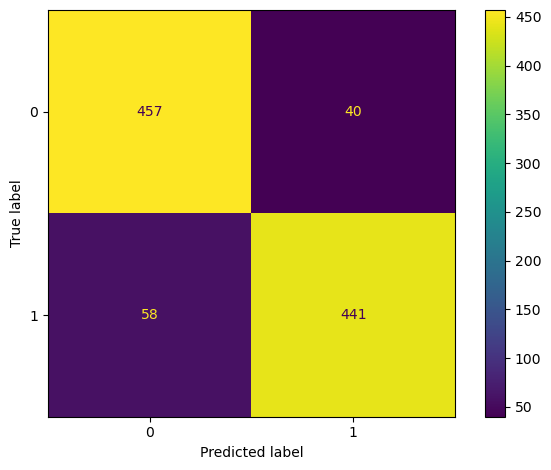

In [561]:
# Creating a Confusion matrix from my stacking model
cm = ConfusionMatrixDisplay.from_estimator(stacked_model_2, X_test, y_test)
plt.tight_layout()
plt.savefig('../project-3/Images/confusion_matrix.png')

### My confusion matrix supports what I expected from my stacking score, my model is  overfit and I have some type 1 and type 2 errors. If I had more time I would work more on reducing my variance but, all in all, I am happy with the model. I do have more false negatives (type 1 errors) than I would like. The idea is to catch as many sleep training category individuals as I can in order to optimize for my problem statement which is to sell baby monitoring equipment to those that would need them. Here I would be missing out on potential customers. I would rather have more false positives in this case (type 2 errors) as the individuals who are classified incorrectly as sleep trainers may have posted something that was similar to someone in the sleep training camp and may be open to purchasing baby monitoring equipment. 

In [553]:
# Saving true negative, false positive, false negative and true positive values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [554]:
# Confirming accuracy
stacked_model_2.score(X_test, y_test)

0.9016064257028112

In [556]:
# Calculating Specificity
spec = tn / (tn + fp)
spec

0.9195171026156942

### This is the proportion of actual negatives identified by my model. My stacked model can identify an individual posting in the Attachment Parenting Subreddit approximately 92% of the time.

In [557]:
# Calculating sensitivity
recall = recall_score(y_test, preds)
recall

0.8837675350701403

### This is the proportion of actual positives identified by my model. My stacked model can correctly identify an individual posting in the Sleep Training Subreddit approximately 88% of the time. As I said before, I would rather have a higher sensitivity than specificity for my model as I would want to sell to as many Sleep Training individuals as possible.

In [558]:
# Calculating precision
precision = precision_score(y_test, preds)
precision

0.9168399168399168

### This is proportion of the positives that my model predicted that are correct. This is not as crucial to my model based on my problem statement as false positives are not as important as my hit rate.

In [559]:
# Calculating F1 score
f1_score = f1_score(y_test, preds)
f1_score

0.8999999999999999

### Ideally this would be higher. This is the harmonic mean of my precision and recall score. Recall is another word for sensitivity which is what I would want to optimize for. However, since my recall is lower than my precision my F1 score is lower as well. That being said, if I had to choose I would exchange precision for sensitivity so the F1 score is not as important to me.

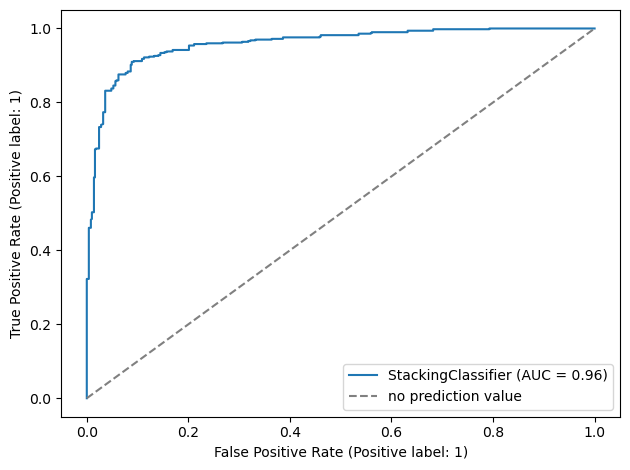

In [562]:
# Creating ROC Curve
RocCurveDisplay.from_estimator(stacked_model_2, X_test, y_test)

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label = 'no prediction value', linestyle = '--', color = 'gray')

# add a legend
plt.legend();
plt.tight_layout()
plt.savefig('../project-3/Images/roc_curve.png')

#### All in all, not a terrible model. The ROC curve looks good. it is not at a 90 degree angle but my stacked model does a decent job of classifying both categories. I would like to do more optimization of the model if I were to be working on this for an actual company. I believe that I could optimize my feature selection more. I would like to utilize PCA to do that. I could also incorporate the self text from the Subreddits. It would take more time in processing and cleaning but at least it would give me a chance to use regex more.  I would also pull more data and see how my current models performed and optimize for better ones! I have found this project very enjoyable and would be happy to spend another week on it if I could.